In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import numpy as np
import matplotlib.pyplot as plt
import dragoman as dm
from scipy import stats
import scipy

In [2]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

# Generate some toy data

Assuming uniform distribution of background, and a Gaussian for signal.

Weights are uniform for background, and ones for signal

In [49]:
signal = True
N_bkgd = 250
N_sig = 15

In [50]:
def gen_data(N_bkgd, N_sig, signal=True):
    
    if not signal:
        N_bkgd += N_sig
    
    x = np.cumsum(np.random.rand(N_bkgd))
    w = np.random.rand(N_bkgd)

    x -= np.min(x)
    x /= np.max(x)

    if signal:
        signal_x = np.random.randn(N_sig) / 30 + 0.3
        signal_w = np.ones_like(signal_x)

        x = np.concatenate([x, signal_x])
        w = np.concatenate([w, signal_w])

        indices = np.argsort(x)
        x = x[indices]
        w = w[indices]

        x -= np.min(x)
        x /= np.max(x)
        
    # exclude first and last
    x = x[1:-1]
    w = w[1:-1]
        
    return x, w

In [51]:
x, w = gen_data(N_bkgd, N_sig, signal)

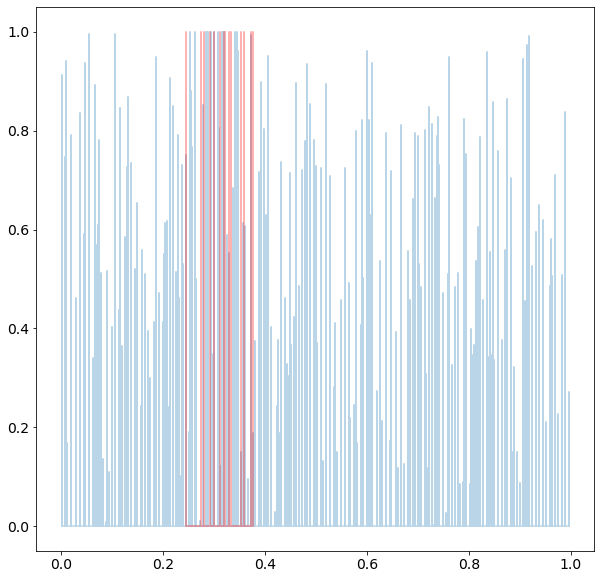

In [52]:
plt.plot(np.repeat(x, 3), np.stack([np.zeros_like(w), w, np.zeros_like(w)]).T.ravel(), alpha=0.3)

if signal:
    plt.plot(np.repeat(signal_x, 3), np.stack([np.zeros_like(signal_w), signal_w, np.zeros_like(signal_w)]).T.ravel(), alpha=0.3, c='r')

# Test

We test the difference of the cdf to the expectation of a normal distribution

Assuming Binomial statistics, the probability should be ${n\choose k}p^k(1-p)^{(n-k)}$, where $p$ is the expected probabilit at position $x$, which is just $x$ (since we normed to $[0,1]$)). $k$ is the number of samples up to point $x$, $n$ total number of samples.

I tried to naivly extend this to weighted events....where $n$ becomes $\sum_0^n weights$, $k = \sum_0^i{weights}$, and the binomal coefficient i have no idea, just using what scipy spits out for non-integers

In [53]:
# unweighted
n = x.size 
k = np.arange(n)
p = scipy.special.binom(n, k) * x**k * (1-x)**(n-k)

# weighted
nw = np.sum(w)
kw = np.cumsum(w)
pw = scipy.special.binom(nw, kw) * x**kw * (1-x)**(nw-kw)

Here I just plot everything. Distributions, CDFs, p-values, ...

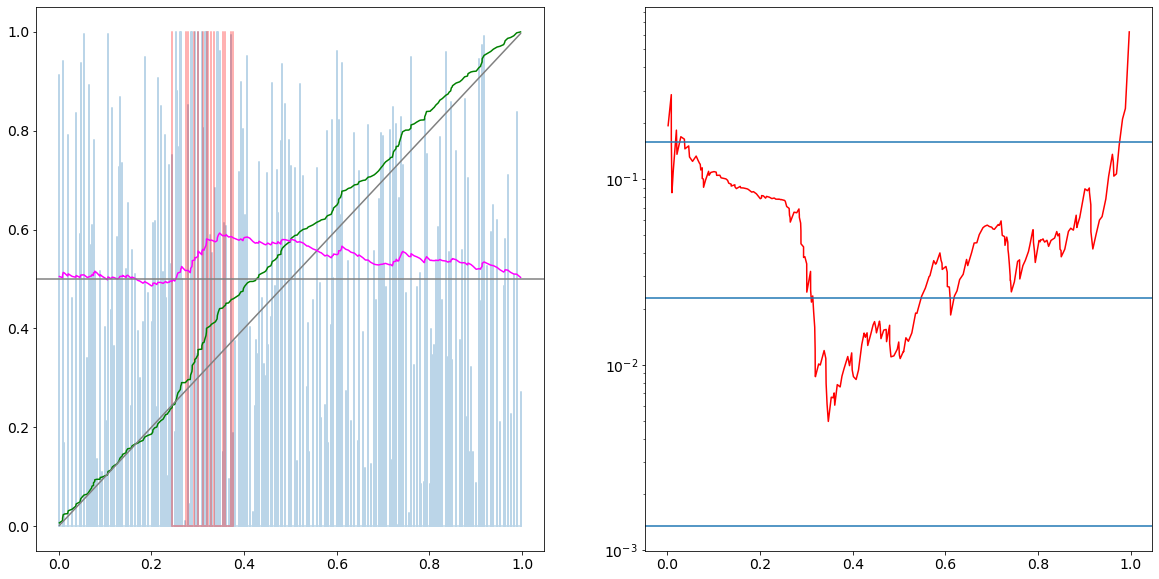

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(np.repeat(x, 3), np.stack([np.zeros_like(w), w, np.zeros_like(w)]).T.ravel(), alpha=0.3)

if signal:
    ax[0].plot(np.repeat(signal_x, 3), np.stack([np.zeros_like(signal_w), signal_w, np.zeros_like(signal_w)]).T.ravel(), alpha=0.3, c='r')

ax[0].plot(x, np.cumsum(w)/np.sum(w), c='green')
ax[0].plot(x, x, c='grey')

ax[0].plot(x, np.cumsum(w)/np.sum(w) - x + 0.5, c='magenta')
ax[0].axhline(0.5, c='grey')

#ax[1].plot(x, p, c='r', ls='--')
ax[1].plot(x, pw, c='r', ls='-')

ax[1].axhline(1-stats.norm.cdf(1))
ax[1].axhline(1-stats.norm.cdf(2))
ax[1].axhline(1-stats.norm.cdf(3))

ax[1].set_yscale('log')

# Trials

In [55]:
p_bkgd = []
p_sig = []


for i in range(10000):
    x, w = gen_data(N_bkgd, N_sig, True)
    # weighted
    nw = np.sum(w)
    kw = np.cumsum(w)
    pw = scipy.special.binom(nw, kw) * x**kw * (1-x)**(nw-kw)
    
    p_sig.append(np.min(pw))

    x, w = gen_data(N_bkgd, N_sig, False)
    # weighted
    nw = np.sum(w)
    kw = np.cumsum(w)
    pw = scipy.special.binom(nw, kw) * x**kw * (1-x)**(nw-kw)
    
    p_bkgd.append(np.min(pw))

Text(0.5, 0, 'p-value')

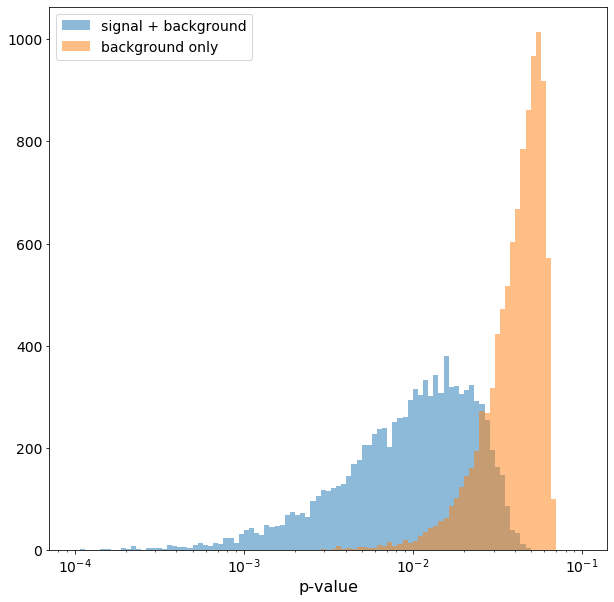

In [56]:
bins = np.logspace(-4, -1, 100)

plt.hist(p_sig, bins=bins, alpha=0.5, label='signal + background')
plt.hist(p_bkgd, bins=bins, alpha=0.5, label='background only')

plt.gca().set_xscale('log')
plt.legend()

plt.gca().set_xlabel('p-value')

Something is a bit off with the p-value...but the distributions look nice